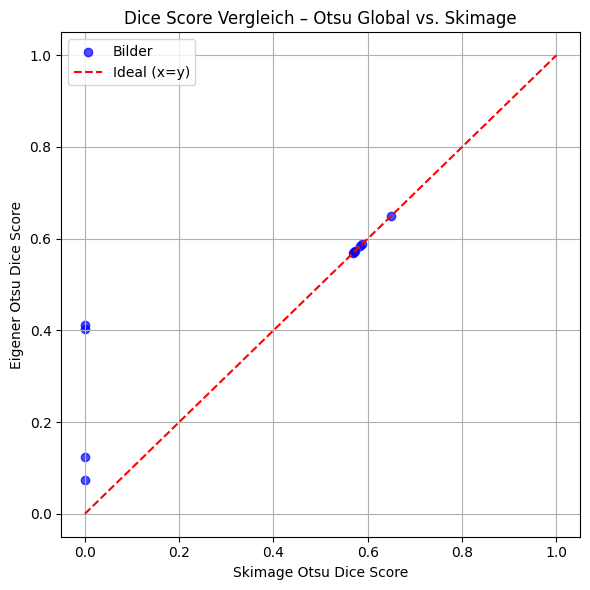

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from skimage.filters import threshold_otsu

# Custom-Module
project_root = os.getcwd()
src_dir = os.path.join(project_root, "src")
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

from otsu_global import otsu_threshold, binarize
from gray_hist import compute_gray_histogram
from Dice_Score import dice_score

# Bilder finden
img_paths = sorted(glob(os.path.join(project_root, "data-git", "**", "img", "*.tif"), recursive=True))

# Ergebnisse
dice_ours = []
dice_skimage = []
labels = []

for img_path in img_paths:
    rel_path = os.path.relpath(img_path, os.path.join(project_root, "data-git"))
    dataset = rel_path.split(os.sep)[0]
    img_name = os.path.basename(img_path)
    number = ''.join(filter(str.isdigit, img_name))
    gt_name = f"man_seg{number}.tif"
    gt_path = os.path.join(project_root, "data-git", dataset, "gt", gt_name)

    if not os.path.exists(gt_path):
        print(f"⚠️  Keine Ground Truth: {gt_path}")
        continue

    # Bild & GT laden
    img = np.array(Image.open(img_path).convert("L"))
    gt = np.array(Image.open(gt_path).convert("L")) > 0

    # 🧠 Dein Otsu
    hist, _ = compute_gray_histogram(img)
    p = hist / hist.sum()
    t_ours = otsu_threshold(p)
    bin_ours = binarize(img, t_ours)

    # 🛠️ Skimage Otsu
    t_ski = threshold_otsu(img)
    bin_ski = img > t_ski

    # Dice Scores
    score_ours = dice_score(gt, bin_ours)
    score_ski = dice_score(gt, bin_ski)

    # Ergebnisse speichern
    dice_ours.append(score_ours)
    dice_skimage.append(score_ski)
    labels.append(rel_path)

# 📊 Scatterplot
plt.figure(figsize=(6,6))
plt.scatter(dice_skimage, dice_ours, alpha=0.7, color='blue', label='Bilder')
plt.plot([0,1], [0,1], 'r--', label='Ideal (x=y)')
plt.xlabel("Skimage Otsu Dice Score")
plt.ylabel("Eigener Otsu Dice Score")
plt.title("Dice Score Vergleich – Otsu Global vs. Skimage")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
